The statement problem is to build an AI model solution that ask to re-allocate the budget across various paid media channels to optimize customer acquisition and conversion rates.

In [ ]:
#list used
%pip install pandas==2.2.2
%pip install numpy==1.26.4
%pip install matplotlib==3.9.1
%pip install sklearn==1.5.1
%pip install seaborn==0.133.2

In [36]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

**Load Dataset**

In [23]:
# Load datasets
googleads_performance = pd.read_csv('/Users/vivekchahal/developer/ML/netelixir/NetElixir/googleads-performance.csv')
metaads_performance = pd.read_csv('/Users/vivekchahal/developer/ML/netelixir/NetElixir/metaads-performance.csv')
microsoftads_performance = pd.read_csv('/Users/vivekchahal/developer/ML/netelixir/NetElixir/microsoftads-performance.csv')
website_landings = pd.read_csv('/Users/vivekchahal/developer/ML/netelixir/NetElixir/website-landings.csv')
googleads_performance.columns = googleads_performance.columns.str.capitalize()
metaads_performance.columns = metaads_performance.columns.str.capitalize()
microsoftads_performance.columns = microsoftads_performance.columns.str.capitalize()
website_landings.columns = website_landings.columns.str.capitalize()

In [24]:
googleads_performance.info()
metaads_performance.info()
microsoftads_performance.info()
website_landings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           714 non-null    object 
 1   Campaign type  714 non-null    object 
 2   Impressions    714 non-null    int64  
 3   Clicks         714 non-null    int64  
 4   Cost           714 non-null    float64
 5   Conversions    714 non-null    float64
 6   Revenue        714 non-null    float64
dtypes: float64(3), int64(2), object(2)
memory usage: 39.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182 entries, 0 to 181
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         182 non-null    object 
 1   Impressions  182 non-null    int64  
 2   Reach        182 non-null    int64  
 3   Cost         182 non-null    float64
 4   Clicks       182 non-null    int64  
 5   Conversions  182 non-null    int64

**Data Preprocessing**

In [26]:
# Handling Duplicates
googleads_performance.drop_duplicates(inplace=True)
metaads_performance.drop_duplicates(inplace=True)
microsoftads_performance.drop_duplicates(inplace=True)
website_landings.drop_duplicates(inplace=True)

# Imputing missing values
imputer = SimpleImputer(strategy='mean')

# Google Ads
googleads_performance['Campaign type'].fillna('Unknown', inplace=True)
googleads_performance[['Impressions', 'Clicks', 'Cost', 'Conversions', 'Revenue']] = imputer.fit_transform(
    googleads_performance[['Impressions', 'Clicks', 'Cost', 'Conversions', 'Revenue']])

# Meta Ads
metaads_performance[['Impressions', 'Reach', 'Cost', 'Clicks', 'Conversions', 'Revenue']] = imputer.fit_transform(
    metaads_performance[['Impressions', 'Reach', 'Cost', 'Clicks', 'Conversions', 'Revenue']])

# Microsoft Ads
microsoftads_performance['Campaign type'].fillna('Unknown', inplace=True)
microsoftads_performance[['Impressions', 'Clicks', 'Cost', 'Conversions', 'Revenue']] = imputer.fit_transform(
    microsoftads_performance[['Impressions', 'Clicks', 'Cost', 'Conversions', 'Revenue']])

# Website Landings
website_landings['Source'].fillna('Unknown', inplace=True)
website_landings['Campaign type'].fillna('Unknown', inplace=True)

/var/folders/1k/w2_r0tq95bdg2rjqxprgq2zr0000gn/T/ipykernel_45521/730339659.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  googleads_performance['Campaign type'].fillna('Unknown', inplace=True)
/var/folders/1k/w2_r0tq95bdg2rjqxprgq2zr0000gn/T/ipykernel_45521/730339659.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we a

In [27]:
# Ensure 'Date' columns are in datetime format
googleads_performance['Date'] = pd.to_datetime(googleads_performance['Date'], errors='coerce')
metaads_performance['Date'] = pd.to_datetime(metaads_performance['Date'], errors='coerce')
microsoftads_performance['Date'] = pd.to_datetime(microsoftads_performance['Date'], errors='coerce')
website_landings['Website landing time'] = pd.to_datetime(website_landings['Website landing time'], errors='coerce')

## Transform 'User id' to hexadecimal string
def transform_user_id(user_id):
    try:
        if isinstance(user_id, float):
            user_id = int(user_id)
        if isinstance(user_id, int):
            return hex(user_id)
        if isinstance(user_id, str):
            if user_id.isdigit():
                return hex(int(user_id))
            return user_id
    except ValueError:
        return user_id

website_landings['User id'] = website_landings['User id'].apply(transform_user_id)

## Handling Incorrect Data Entries
# Replace negative values with 0
def clean_data(df, columns):
    for col in columns:
        df[col] = np.where(df[col] < 0, 0, df[col])

# Apply to each DataFrame
clean_data(googleads_performance, ['Impressions', 'Clicks', 'Cost', 'Conversions', 'Revenue'])
clean_data(metaads_performance, ['Impressions', 'Reach', 'Cost', 'Clicks', 'Conversions', 'Revenue'])
clean_data(microsoftads_performance, ['Impressions', 'Clicks', 'Cost', 'Conversions', 'Revenue'])

# Ensure 'Is converted' column only contains binary values
website_landings['Is converted'] = np.where(website_landings['Is converted'].isin([0, 1]), website_landings['Is converted'], np.nan)
website_landings['Is converted'].fillna(0, inplace=True)

/var/folders/1k/w2_r0tq95bdg2rjqxprgq2zr0000gn/T/ipykernel_45521/1334785468.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  website_landings['Is converted'].fillna(0, inplace=True)


In [28]:
# Rename columns in website_landings for consistency
website_landings.rename(columns={
    'Website landing time': 'Date',
    'Is converted': 'Conversions',
    'Channel': 'Channel',
    'Campaign type': 'Campaign type'
}, inplace=True)

# Aggregate website landings data by Date, Channel, and Campaign type
website_conversions = website_landings.groupby(['Date', 'Channel', 'Campaign type','Source']).agg({
    'Conversions': 'sum',
    'User id': 'count'  # Assuming User id represents impressions
}).rename(columns={'User id': 'Impressions'}).reset_index()

# Display the first few rows of the aggregated website conversions data
print(website_conversions.head())

                 Date Channel  Campaign type    Source  Conversions  \
0 2024-01-01 00:01:31    paid  Cross-network    google          0.0   
1 2024-01-01 00:01:53  direct        Unknown   Unknown          0.0   
2 2024-01-01 00:01:59    paid  Cross-network    google          0.0   
3 2024-01-01 00:02:02    paid  Cross-network    google          0.0   
4 2024-01-01 00:02:05    paid        Unknown  facebook          0.0   

   Impressions  
0            1  
1            1  
2            1  
3            1  
4            1  



**Data Preperation for Modelling**

In [29]:
# Prepare Google Ads data
googleads_data = googleads_performance[['Date', 'Campaign type', 'Impressions', 'Clicks', 'Cost', 'Conversions', 'Revenue']]

# Prepare Meta Ads data
metaads_data = metaads_performance[['Date', 'Impressions', 'Clicks', 'Cost', 'Conversions', 'Revenue']]

# Prepare Microsoft Ads data
microsoftads_data = microsoftads_performance[['Date', 'Campaign type', 'Impressions', 'Clicks', 'Cost', 'Conversions', 'Revenue']]

# Concatenate all datasets
ads_performance = pd.concat([googleads_data, metaads_data, microsoftads_data], ignore_index=True)

# Clean the 'Campaign type' field
ads_performance['Campaign type'].fillna('Unknown', inplace=True)

# Aggregate by Date and Campaign type
ads_performance_grouped = ads_performance.groupby(['Date', 'Campaign type']).sum().reset_index()

# Join with website landings data
website_landings_grouped = website_conversions.groupby(['Date','Channel','Campaign type', 'Source']).agg({  # Include 'Source' in the grouping
    'Conversions': 'sum',
    'Impressions':'count'
}).reset_index()

# Ensure the 'Conversions' column from website_landings_grouped is preserved during the merge
final_data = ads_performance_grouped.merge(website_landings_grouped, on=['Date', 'Campaign type'], how='left', suffixes=('_ads', '_website'))

# Fill missing values after merge
final_data.fillna(0, inplace=True)

# Feature Engineering
final_data['Cost_per_Click'] = final_data['Cost'] / np.where(final_data['Clicks'] == 0, 1, final_data['Clicks'])
final_data['Conversion_Rate'] = final_data['Conversions_website'] / np.where(final_data['Clicks'] == 0, 1, final_data['Clicks'])

# Select features and target
features = ['Impressions_ads', 'Clicks', 'Cost', 'Cost_per_Click', 'Conversion_Rate']
target = 'Revenue'

# Splitting the data
X = final_data[features]
y = final_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/var/folders/1k/w2_r0tq95bdg2rjqxprgq2zr0000gn/T/ipykernel_45521/3140472106.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ads_performance['Campaign type'].fillna('Unknown', inplace=True)


# **Model Training**

In [30]:
# --- Model Training ---

## Initialize the RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)

## Train the model
model.fit(X_train, y_train)

## Predictions
y_pred = model.predict(X_test)

## Model evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error (RMSE): {rmse}")
r2 = model.score(X_test, y_test)
print(f"R^2: {r2}")


Root Mean Squared Error (RMSE): 2337.387546885004
R^2: 0.7510529802114719


# RESULT

**Budget Allocation(Including Unknown Channel)**

In [31]:
# Calculate the metrics: Cost per Conversion (CPC), ROI, Conversion Rate
final_data['CPC'] = final_data['Cost'] / np.where(final_data['Conversions_website'] == 0, 1, final_data['Conversions_website'])
final_data['ROI'] = final_data['Revenue'] / np.where(final_data['Cost'] == 0, 1, final_data['Cost'])
final_data['Conversion_Rate'] = final_data['Conversions_website'] / np.where(final_data['Clicks'] == 0, 1, final_data['Clicks'])

# Group by Channel, Campaign type, and Source to calculate aggregate metrics
grouped_metrics = final_data.groupby(['Channel', 'Campaign type', 'Source']).agg({
    'Cost': 'sum',
    'Revenue': 'sum',
    'Conversions_website': 'sum',
    'Clicks': 'sum'
}).reset_index()

# Recalculate CPC, ROI, and Conversion Rate for each group
grouped_metrics['CPC'] = grouped_metrics['Cost'] / np.where(grouped_metrics['Conversions_website'] == 0, 1, grouped_metrics['Conversions_website'])
grouped_metrics['ROI'] = grouped_metrics['Revenue'] / np.where(grouped_metrics['Cost'] == 0, 1, grouped_metrics['Cost'])
grouped_metrics['Conversion_Rate'] = grouped_metrics['Conversions_website'] / np.where(grouped_metrics['Clicks'] == 0, 1, grouped_metrics['Clicks'])

# Normalize the metrics to use them in budget allocation
grouped_metrics['Normalized_CPC'] = 1 / grouped_metrics['CPC']  # Inverted as lower CPC is better
grouped_metrics['Normalized_ROI'] = grouped_metrics['ROI'] / grouped_metrics['ROI'].sum()
grouped_metrics['Normalized_Conversion_Rate'] = grouped_metrics['Conversion_Rate'] / grouped_metrics['Conversion_Rate'].sum()

# Normalize all metrics so their sum equals 1
total_normalized = grouped_metrics[['Normalized_CPC', 'Normalized_ROI', 'Normalized_Conversion_Rate']].sum(axis=1)
grouped_metrics['Total_Normalized'] = total_normalized / total_normalized.sum()

# Allocate the budget
total_budget = 200000
grouped_metrics['Allocated_Budget'] = grouped_metrics['Total_Normalized'] * total_budget
# Display the budget allocation
print("Budget Allocation across Channels, Campaign types, and Sources:")
print(grouped_metrics[['Channel', 'Campaign type', 'Source', 'Allocated_Budget']])


Budget Allocation across Channels, Campaign types, and Sources:
  Channel     Campaign type  Source  Allocated_Budget
0       0          Audience       0       7300.551145
1       0     Cross-network       0      12574.466404
2       0   Display Network       0      14687.168358
3       0   Performance max       0       7205.100497
4       0  Search & content       0       8363.257035
5       0    Search Network       0      19194.367308
6       0          Shopping       0      19544.169654
7       0           Unknown       0      97549.430830
8       0           YouTube       0       1512.267500
9    paid     Cross-network  google      12069.221266


In [32]:
final_data

,Date,Campaign type,Impressions_ads,Clicks,Cost,Conversions_ads,Revenue,Channel,Source,Conversions_website,Impressions_website,Cost_per_Click,Conversion_Rate,CPC,ROI
0,2024-01-01,Audience,9132.0,50.0,26.8,0.0,0.0,0,0,0.0,0.0,0.536000,0.0,26.8,0.000000
1,2024-01-01,Cross-network,143669.0,896.0,656.3,6.5,1410.3,0,0,0.0,0.0,0.732478,0.0,656.3,2.148865
2,2024-01-01,Display Network,3.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.000000,0.0,0.0,0.000000
3,2024-01-01,Performance max,897.0,9.0,7.0,0.0,0.0,0,0,0.0,0.0,0.777778,0.0,7.0,0.000000
4,2024-01-01,Search & content,95977.0,561.0,846.5,1.0,168.8,0,0,0.0,0.0,1.508913,0.0,846.5,0.199409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,2024-12-06,Search & content,46431.0,336.0,519.6,9.0,1616.5,0,0,0.0,0.0,1.546429,0.0,519.6,3.111047
637,2024-12-06,Search Network,8237.0,559.0,1994.2,38.0,10142.2,0,0,0.0,0.0,3.567442,0.0,1994.2,5.085849
638,2024-12-06,Shopping,51972.0,193.0,166.5,8.0,549.0,0,0,0.0,0.0,0.862694,0.0,166.5,3.297297
639,2024-12-06,Unknown,7578.0,96.0,62.8,16.0,3662.7,0,0,0.0,0.0,0.654167,0.0,62.8,58.323248


**Data Visualization**

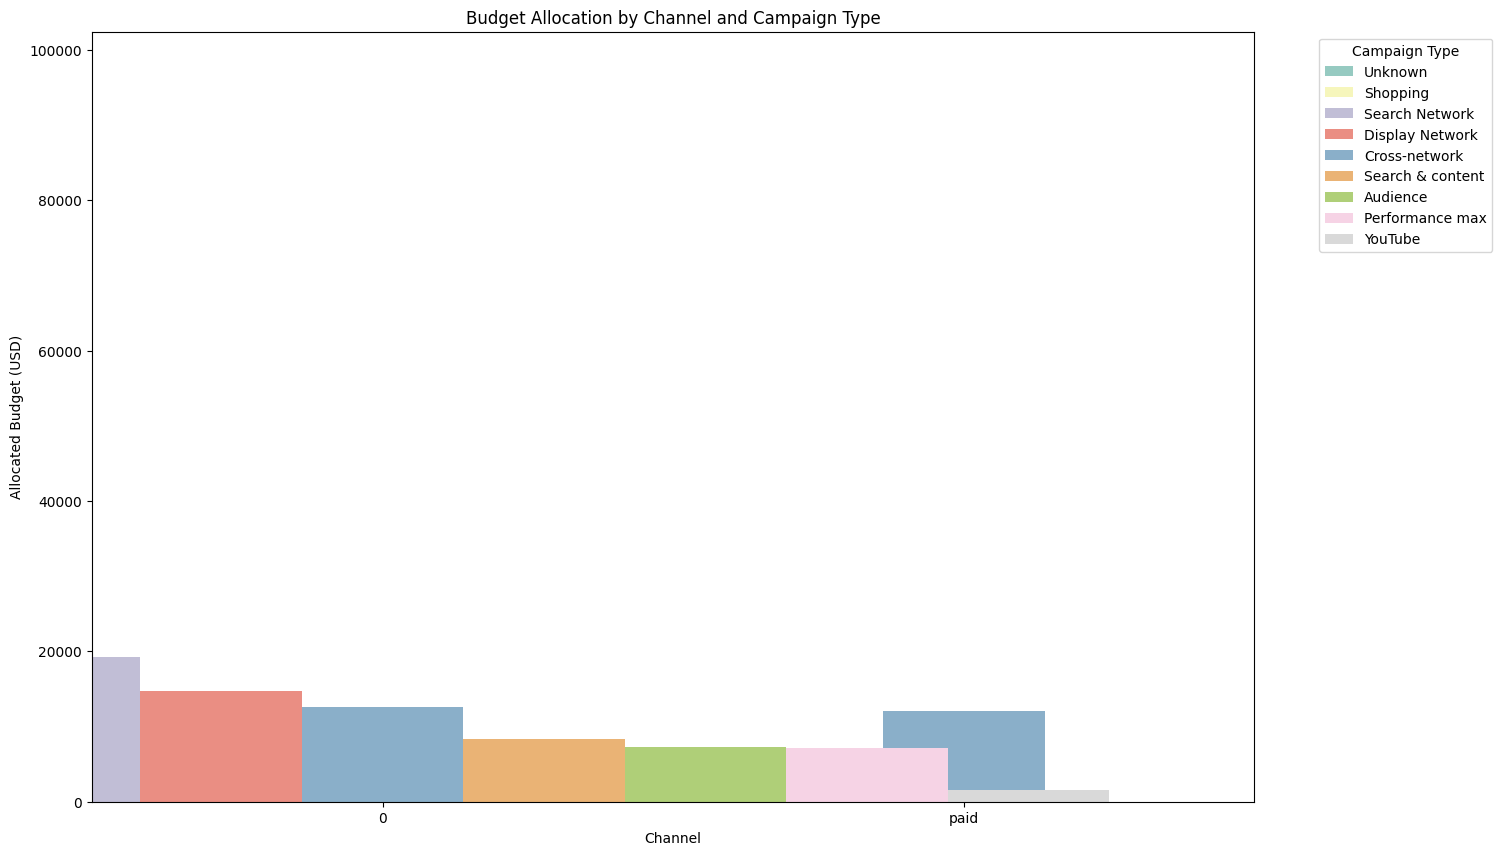

In [37]:
# Convert the Allocated_Budget column back to a numeric format for plotting
grouped_metrics['Allocated_Budget_Numeric'] = grouped_metrics['Allocated_Budget'].replace('[\$,]', '', regex=True).astype(float)

# Set the plot size
plt.figure(figsize=(15, 10))

# Create a vertical bar plot
sns.barplot(
    data=grouped_metrics.sort_values('Allocated_Budget_Numeric', ascending=False),
    x='Channel',
    y='Allocated_Budget_Numeric',
    hue='Campaign type',
    palette='Set3',
    width=2.5
)

# Set plot labels and title
plt.xlabel('Channel')
plt.ylabel('Allocated Budget (USD)')
plt.title('Budget Allocation by Channel and Campaign Type')
plt.legend(title='Campaign Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [40]:
# Budget Allocation after Filtering

filtered_data = final_data[~((final_data['Campaign type'] == 'Unknown') &
                             (final_data['Source'] == 0) &
                             (final_data['Channel'] == 0))].copy()  # Ensure to use .copy() to avoid the SettingWithCopyWarning

# Recalculate the metrics: Cost per Conversion (CPC), ROI, Conversion Rate
filtered_data.loc[:, 'CPC'] = filtered_data['Cost'] / np.where(filtered_data['Conversions_website'] == 0, 1, filtered_data['Conversions_website'])
filtered_data.loc[:, 'ROI'] = filtered_data['Revenue'] / np.where(filtered_data['Cost'] == 0, 1, filtered_data['Cost'])
filtered_data.loc[:, 'Conversion_Rate'] = filtered_data['Conversions_website'] / np.where(filtered_data['Clicks'] == 0, 1, filtered_data['Clicks'])

# Group by Channel, Campaign type, and Source to calculate aggregate metrics
grouped_filtered_metrics = filtered_data.groupby(['Channel', 'Campaign type', 'Source']).agg({
    'Cost': 'sum',
    'Revenue': 'sum',
    'Conversions_website': 'sum',
    'Clicks': 'sum'
}).reset_index()

# Recalculate CPC, ROI, and Conversion Rate for each group
grouped_filtered_metrics.loc[:, 'CPC'] = grouped_filtered_metrics['Cost'] / np.where(grouped_filtered_metrics['Conversions_website'] == 0, 1, grouped_filtered_metrics['Conversions_website'])
grouped_filtered_metrics.loc[:, 'ROI'] = grouped_filtered_metrics['Revenue'] / np.where(grouped_filtered_metrics['Cost'] == 0, 1, grouped_filtered_metrics['Cost'])
grouped_filtered_metrics.loc[:, 'Conversion_Rate'] = grouped_filtered_metrics['Conversions_website'] / np.where(grouped_filtered_metrics['Clicks'] == 0, 1, grouped_filtered_metrics['Clicks'])

# Normalize the metrics to use them in budget allocation
grouped_filtered_metrics['Normalized_CPC'] = 1 / grouped_filtered_metrics['CPC']  # Inverted as lower CPC is better
grouped_filtered_metrics['Normalized_ROI'] = grouped_filtered_metrics['ROI'] / grouped_filtered_metrics['ROI'].sum()
grouped_filtered_metrics['Normalized_Conversion_Rate'] = grouped_filtered_metrics['Conversion_Rate'] / grouped_filtered_metrics['Conversion_Rate'].sum()

# Normalize all metrics so their sum equals 1
total_normalized_filtered = grouped_filtered_metrics[['Normalized_CPC', 'Normalized_ROI', 'Normalized_Conversion_Rate']].sum(axis=1)
grouped_filtered_metrics['Total_Normalized'] = total_normalized_filtered / total_normalized_filtered.sum()

# Allocate the budget
total_budget = 200000  # Example total budget in USD
grouped_filtered_metrics['Allocated_Budget'] = grouped_filtered_metrics['Total_Normalized'] * total_budget

# Format the Allocated Budget as USD with dollar symbol
grouped_filtered_metrics['Allocated_Budget'] = grouped_filtered_metrics['Allocated_Budget'].apply(lambda x: f"${x:,.2f}")

# Display the budget allocation
print("Budget Allocation across Channels, Campaign types, and Sources after filtering:")
print(grouped_filtered_metrics[['Channel', 'Campaign type', 'Source', 'Allocated_Budget']])

     

Budget Allocation across Channels, Campaign types, and Sources after filtering:
  Channel     Campaign type  Source Allocated_Budget
0       0          Audience       0       $15,321.74
1       0     Cross-network       0       $26,586.73
2       0   Display Network       0       $14,688.88
3       0   Performance max       0       $15,178.85
4       0  Search & content       0       $17,679.88
5       0    Search Network       0       $40,583.05
6       0          Shopping       0       $41,309.13
7       0           YouTube       0        $3,164.39
8    paid     Cross-network  google       $25,487.35
